# Import Library

In [34]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Import Gambar dari Kaggle 

In [2]:
train_dir = '/kaggle/input/intel-image-classification/seg_train/seg_train'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test'

Insight:
* Karena dari author dataset tersebut, sudah ada pembagian test dan training data, maka kita bisa langsung memulai saja, dari pembagian tersebut

# Generator Dengan Split 15%

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)

# Load Training Dataset dan Validation Dataset

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/kaggle/input/intel-image-classification/seg_test/seg_test',
    target_size=(224, 224), 
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15,
    rotation_range=15,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    '/kaggle/input/intel-image-classification/seg_train/seg_train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/kaggle/input/intel-image-classification/seg_train/seg_train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3000 images belonging to 6 classes.
Found 11932 images belonging to 6 classes.
Found 2102 images belonging to 6 classes.


# Membangun Model CNN

In [19]:
resnet_base = ResNet50(weights='/kaggle/input/source/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224,224,3))

for layer in resnet_base.layers[-20:]:
    layer.trainable = True

model = Sequential([
    Input(shape=(224, 224, 3)),
    resnet_base,  
    Conv2D(64, (3, 3), activation='relu', padding='same'),  
    MaxPooling2D(2, 2),                                    
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax') 
])

model.compile(optimizer=Adam(learning_rate=1e-5),  
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Insight:
* Menggunakan ResNet50 sebagai bahan dasar, serta sequential karena sudah pretrained di ImageNet, sehingga mempercepat proses training dan meningkatkan akurasi tanpa harus membangun CNN dari nol.

# Training Data

In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_sequential.keras', save_best_only=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop, model_checkpoint, lr_reduction]
)

Epoch 1/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 163s 430ms/step - accuracy: 0.9362 - loss: 0.2049 - val_accuracy: 0.9282 - val_loss: 0.2318 - learning_rate: 5.0000e-06
Epoch 2/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 148s 388ms/step - accuracy: 0.9405 - loss: 0.1839 - val_accuracy: 0.9291 - val_loss: 0.2392 - learning_rate: 5.0000e-06
Epoch 3/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 147s 387ms/step - accuracy: 0.9450 - loss: 0.1684 - val_accuracy: 0.9301 - val_loss: 0.2445 - learning_rate: 5.0000e-06
Epoch 4/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9537 - loss: 0.1462
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
373/373 ━━━━━━━━━━━━━━━━━━━━ 148s 390ms/step - accuracy: 0.9537 - loss: 0.1462 - val_accuracy: 0.9267 - val_loss: 0.2391 - learning_rate: 5.0000e-06
Epoch 5/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 146s 385ms/step - accuracy: 0.9558 - loss: 0.1447 - val_accuracy: 0.9310 - val_loss: 0.2425 - learning_rate: 2.5000e-06
Epoch 6/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 147s 38

Insight: 
* Training berhenti pada epoch ke-6 ini disebabkan oleh tidak ada peningkatan signifikan pada val_loss selama 5 epoch berturut-turut, sesuai dengan ketentuan EarlyStopping. Artinya model dianggap sudah mencapai performa terbaiknya di epoch ke-6.

# Plot Hasil

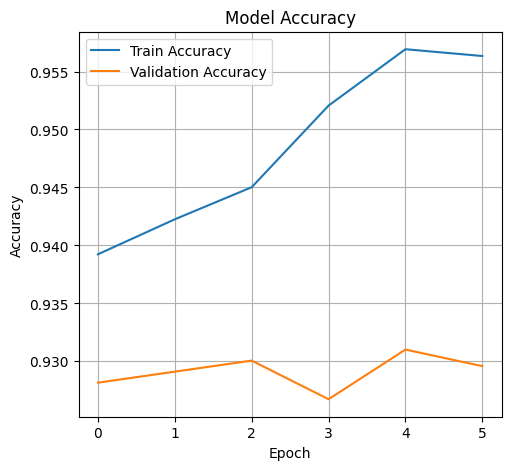

In [22]:
# Plot Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

Insight:
* Train accuracy memiliki peningkatan dari awal epoch sampai akhir, namun angka tersebut tidak signifikan dan ini juga menunjukkan model belajar dengan baik, dengan adanya peningkatan tersebut
* Validation accuracy terlihat tidak stabil, terutama terjadi fluktuasi antara epoch ke-2 dan ke-3, yang menunjukkan model belum sepenuhnya generalisasi dengan baik terhadap data validasi.

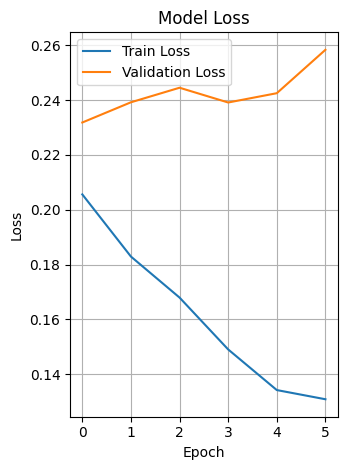

In [23]:
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Insight:
* Train loss menunjukkan penurunan konsisten di setiap epoch, menandakan model belajar dengan baik dari data training.
* Sebaliknya, validation loss cenderung naik di akhir-akhir epoch, terutama pada epoch ke-5, yang mengindikasikan awal dari overfitting karena model semakin bagus di training, tapi semakin buruk di validasi.

# Evaluasi Test Set

In [24]:
model = load_model('resnet_sequential.keras')  
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - accuracy: 0.9441 - loss: 0.1807

Test Accuracy: 93.33%


# Inference Dengan SavedModel

In [32]:
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_7')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  134721887155680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134721887149344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134721887255568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134721887249584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134721887143712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134721887146176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134721887245888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134721887247120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134721887252928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134721887242720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134721887244128: T

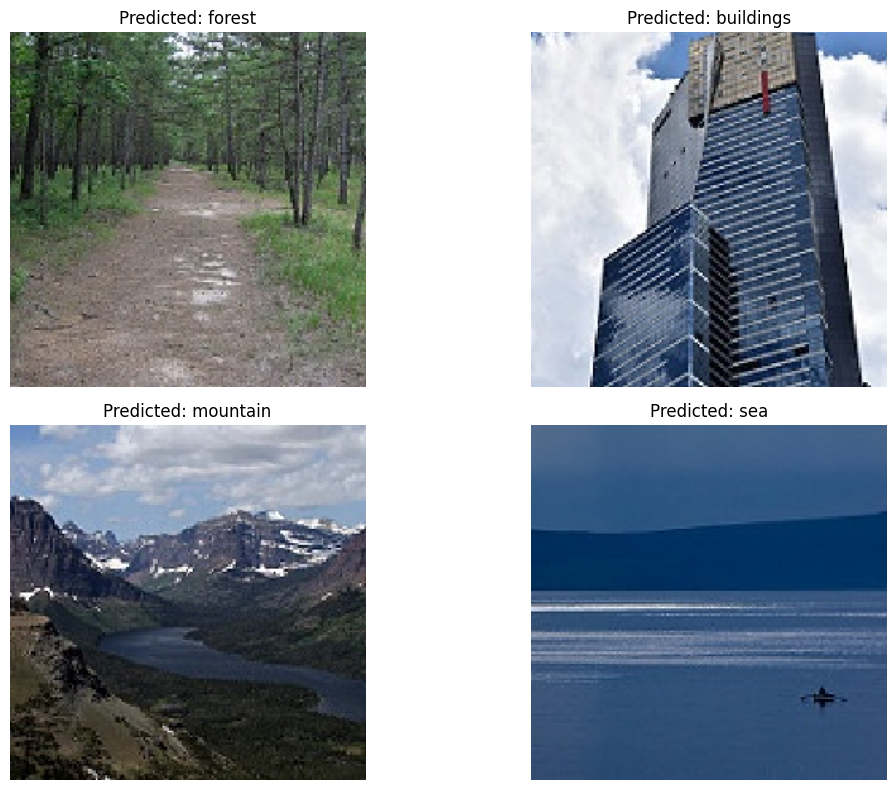

In [37]:
img_paths = [
    '/kaggle/input/intel-image-classification/seg_test/seg_test/forest/20056.jpg',
    '/kaggle/input/intel-image-classification/seg_test/seg_test/buildings/20057.jpg',
    '/kaggle/input/intel-image-classification/seg_test/seg_test/glacier/20109.jpg',
    '/kaggle/input/intel-image-classification/seg_test/seg_test/sea/20124.jpg'
]

loaded = tf.saved_model.load('saved_model')
infer = loaded.signatures["serving_default"]

class_names = list(train_generator.class_indices.keys())

plt.figure(figsize=(12, 8))

for i, path in enumerate(img_paths):
    img = image.load_img(path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, axis=0)

    output = infer(img_array)
    pred = output['output_0'].numpy()
    predicted_class = class_names[np.argmax(pred)]
    plt.subplot(2, 2, i + 1)  
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Kesimpulan: 
* Model telah belajar dengan sangat baik, ditunjukkan oleh akurasi test sebesar 93.33%, yang sudah melampaui batas minimum keberhasilan sebesar 85%.

* Berdasarkan hasil prediksi terhadap beberapa gambar, model mampu melakukan klasifikasi dengan akurasi visual yang sesuai dan relevan terhadap label yang sebenarnya.

* Hal ini menunjukkan bahwa model sudah cukup andal untuk digunakan dalam aplikasi klasifikasi gambar di dunia nyata, khususnya untuk kategori yang serupa.